# Análise Exploratória de Dados
## Importando bibliotecas

In [11]:
from src.data import prepare
#from src.data import process
from src.data import visualize

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from PIL import Image

plt.style.use('seaborn-notebook')
%matplotlib inline

## Pré-processando os dados

In [2]:
true_path = "../data/raw/full_texts/true/"
fake_path = "../data/raw/full_texts/fake/"
output_path = "../data/interim/news.csv"

prepare.make_text_dataframe(true_path, fake_path, output_path)

## Importando dados pré-processados

In [3]:
news_df = pd.read_csv(output_path)
news_df.sample(10)

,text,label
725,Tom Cavalcante estrela Os parças com Whinderss...,true
4425,Governo armou encenação na campanha de combate...,fake
1361,As lições da Islândia no combate à diferença s...,true
1516,Protesto de professores municipais tem tumulto...,true
906,O estranho lago que aparece e desaparece na Bo...,true
6284,Mais invasão! MST e CUT ocupam sede do governo...,fake
6537,"Tirando onda: ""Mesmo que eu perca na Câmara, n...",fake
4949,"""Alta cúpula do judiciário pode estar entre as...",fake
365,Dia da Mulher: ex-catadora de lixo no DF conta...,true
2689,"Segunda-feira, 26 de fevereiro . Bom dia! Aqui...",true


## Analisando os dados obtidos

### Quantidade de dados

In [4]:
news_df['label'].value_counts()

true    3600
fake    3600
Name: label, dtype: int64

*O número de dados do corpus utilizado está equilibrado. 
Há um número igual de textos verdadeiros (true) e falsos (fake).*

### Comprimento

#### De todo o texto

- Qual o comprimento dos textos obtidos?
- O comprimento dos textos difere entre falsos e verdadeiros?

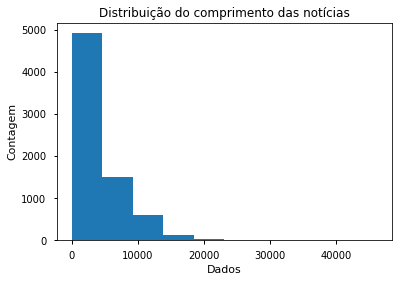

In [5]:
news_df['text_length'] = news_df['text'].str.len()

plt.hist(news_df.text_length)
plt.xlabel('Dados')
plt.ylabel('Contagem')
plt.title('Distribuição do comprimento das notícias')
plt.show()

In [6]:
news_df.text_length.describe()

count     7200.000000
mean      3898.906250
std       4066.717133
min         46.000000
25%        948.000000
50%       2185.500000
75%       5603.250000
max      46084.000000
Name: text_length, dtype: float64

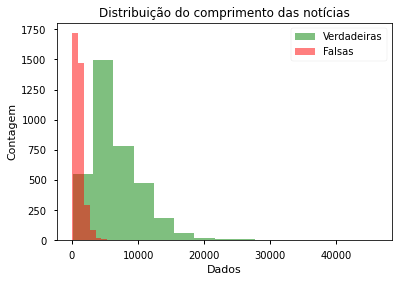

In [7]:
bins = 15
alpha = 0.5

plt.hist(news_df[news_df.label == 'true'].text_length,
         bins=bins,
         alpha=alpha,
         label='Verdadeiras',
         color='green')

plt.hist(news_df[news_df.label == 'fake'].text_length,
         bins=bins,
         alpha=alpha,
         label='Falsas',
         color='red')

plt.xlabel('Dados')
plt.ylabel('Contagem')
plt.title('Distribuição do comprimento das notícias')
plt.legend(loc='upper right')

plt.show()

*As notícias têm entre 46 e cerca de 46000 palavras, se distribuindo de maneira desigual de acordo com sua categoria. O comprimento das notícias verdadeiras tem tamanhos mais variados e mediana superior às notícias falsas, cujo comprimento se concentra numa faixa reduzida.* 

*Dentro desse conjunto de dados, notícias falsas tendem a ser mais curtas.*

#### Das palavras

- Há diferença no tamanho médio das palavras entre as diferentes categorias de notícias?

In [8]:
news_df['mean_word_len'] = news_df['text'].str.split().\
                    apply(lambda text : [len(word) for word in text]).\
                    map(lambda word: np.mean(word))

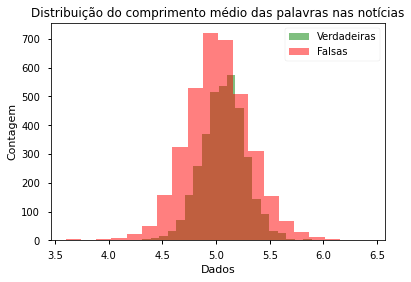

In [9]:
bins = 20
alpha = 0.5

plt.hist(news_df[news_df.label == 'true'].mean_word_len,
         bins=bins,
         alpha=alpha,
         label='Verdadeiras',
         color='green')

plt.hist(news_df[news_df.label == 'fake'].mean_word_len,
         bins=bins,
         alpha=alpha,
         label='Falsas',
         color='red')

plt.xlabel('Dados')
plt.ylabel('Contagem')
plt.title('Distribuição do comprimento médio das palavras nas notícias')
plt.legend(loc='upper right')

plt.show()

*Não parece haver diferença no comprimento médio das palavras utilizadas nas notícias, quaisquer que sejam as categorias.*

### Nuvens de palavras
- As palavras mais usadas nas notícias abordadas estão dentro dos mesmos campos semânticos?

In [12]:
nltk.download('stopwords')
stop = set(stopwords.words('portuguese'))

[nltk_data] Downloading package stopwords to /home/tayna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


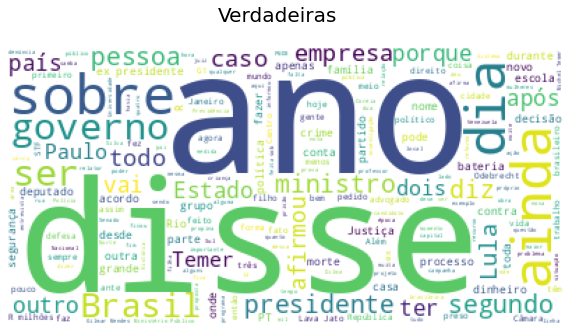

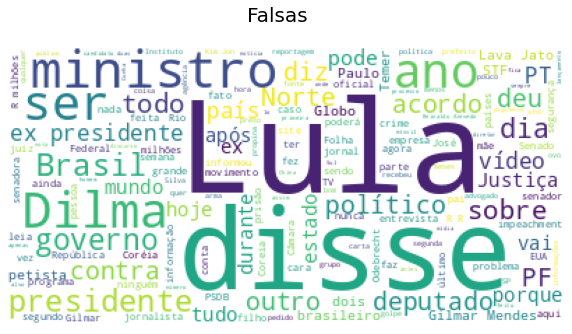

In [15]:
visualize.show_wordcloud(news_df[news_df.label == 'true'].text[0:100], 
               stop, title = 'Verdadeiras')

visualize.show_wordcloud(news_df[news_df.label == 'fake'].text[0:100], 
               stop, title = 'Falsas')

plt.show()